# Factorization Machineで学習する

In [48]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from fastFM import mcmc

In [10]:
# ユーザID、映画ID、評価値を読み込む
def load_data(filename, path='ml-100k/'):
    data = []
    y = []
    with open(path+filename) as f:
        for line in f:
            (user, movieid, rating, ts) = line.split('\t')
            data.append({'user_id': str(user), 'movie_id': str(movieid)})
            y.append(float(rating))
    
    return (data, np.array(y))

In [20]:
# 開発データとテストデータを読み込む
(dev_data, y_dev) = load_data('ua.base')
(test_data, y_test) = load_data('ua.test')

In [37]:
# 開発データを学習データと検証データに分ける
v = DictVectorizer()
X_dev = v.fit_transform(dev_data)
X_test = v.transform(test_data)
X_train, X_dev_test, y_train, y_dev_test = train_test_split(X_dev, y_dev, test_size=0.1, random_state=42)
print('検証データの標準偏差', np.std(y_dev_test))

検証データの標準偏差 1.1189348256323237


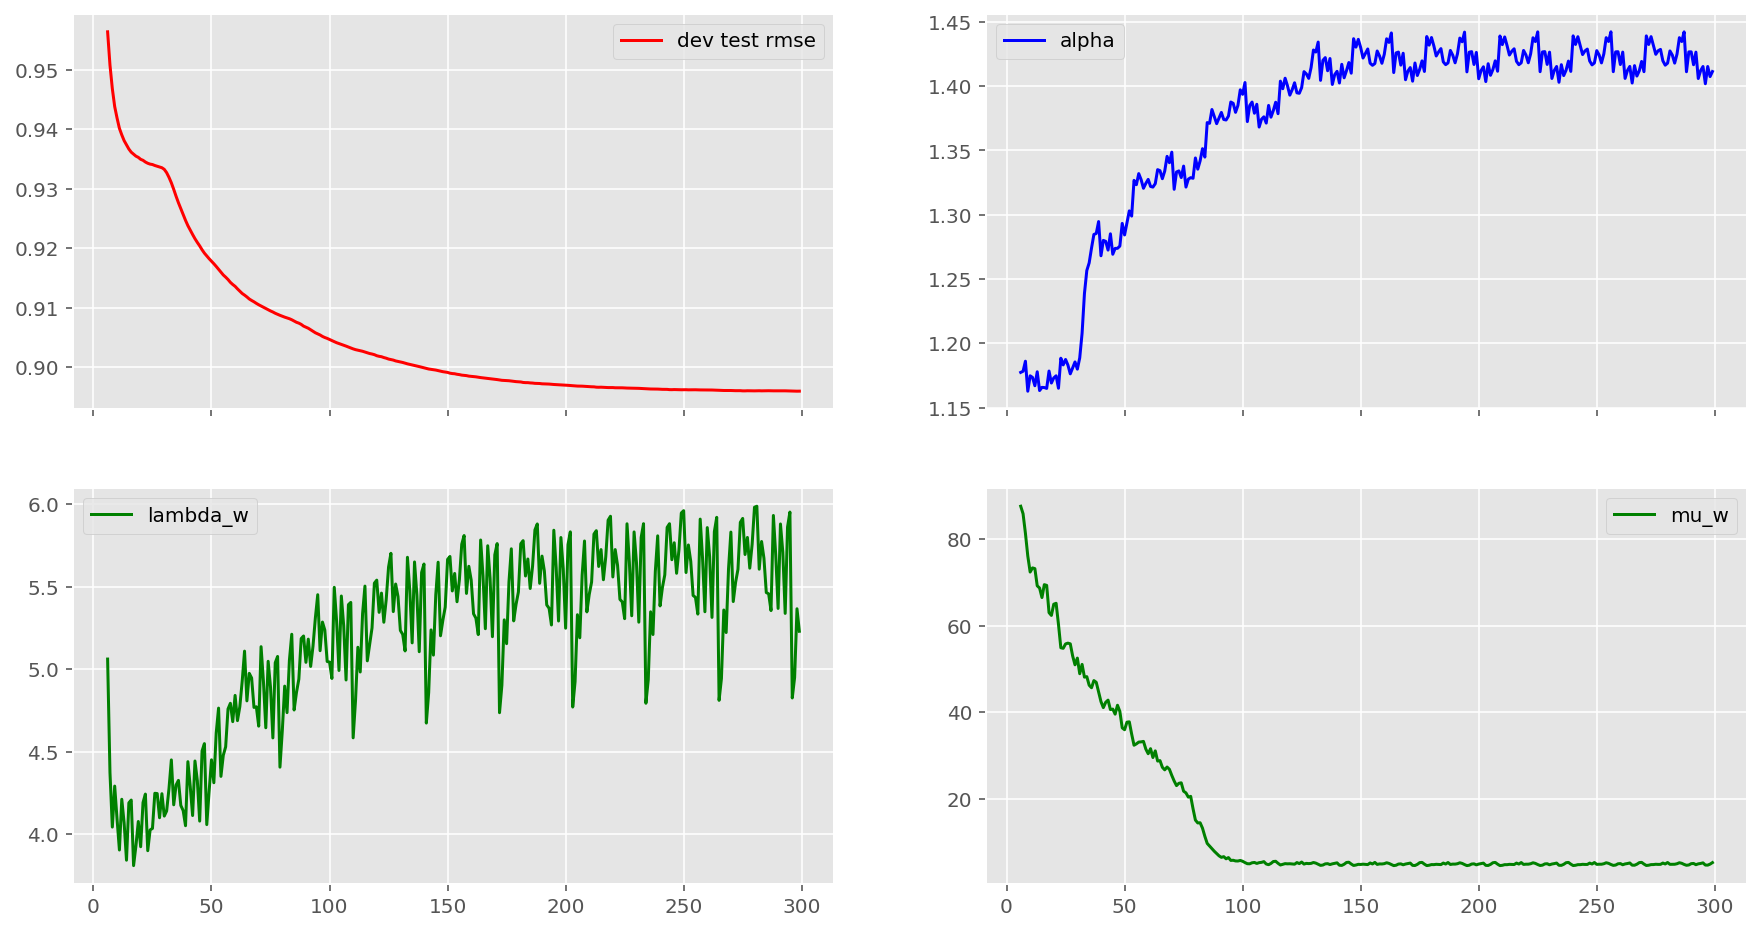

In [30]:
# fastFMのパラメータの指定
n_iter = 300
step_size = 1
seed = 123
rank = 4  # 行列を圧縮する次数

# MCMCを使った回帰のFMモデルを初期化する
fm = mcmc.FMRegression(n_iter=0, rank=rank, random_state=seed)
fm.fit_predict(X_train, y_train, X_dev_test)

rmse_dev_test = []
rmse_test = []

hyper_param = np.zeros((n_iter-1, 3+2*rank), dtype=np.float64)

# イテレーション回数を変化させて、予測結果の性能とハイパーパラメータを得る
for nr, i in enumerate(range(1, n_iter)):
    fm.random_state = i * seed
    y_pred = fm.fit_predict(X_train, y_train, X_dev_test, n_more_iter=step_size)
    rmse_test.append(np.sqrt(mean_squared_error(y_pred, y_dev_test)))
    hyper_param[nr, :] = fm.hyper_param_

# 最初の5回は値が落ち着いていないので無視する
values = np.arange(1, n_iter)
x = values * step_size
burn_in = 5
x = x[burn_in:]

# RMSEとハイパーパラメータをプロットする
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(15, 8))

axes[0, 0].plot(x, rmse_test[burn_in:], label='dev test rmse', color='r')
axes[0, 0].legend()
axes[0, 1].plot(x, hyper_param[burn_in:, 0], label='alpha', color='b')
axes[0, 1].legend()
axes[1, 0].plot(x, hyper_param[burn_in:, 1], label='lambda_w', color='g')
axes[1, 0].legend()
axes[1, 1].plot(x, hyper_param[burn_in:, 3], label='mu_w', color='g')
axes[1, 1].legend()

rank:4	rmse:0.903
rank:8	rmse:0.898
rank:16	rmse:0.896
rank:32	rmse:0.893
rank:64	rmse:0.893


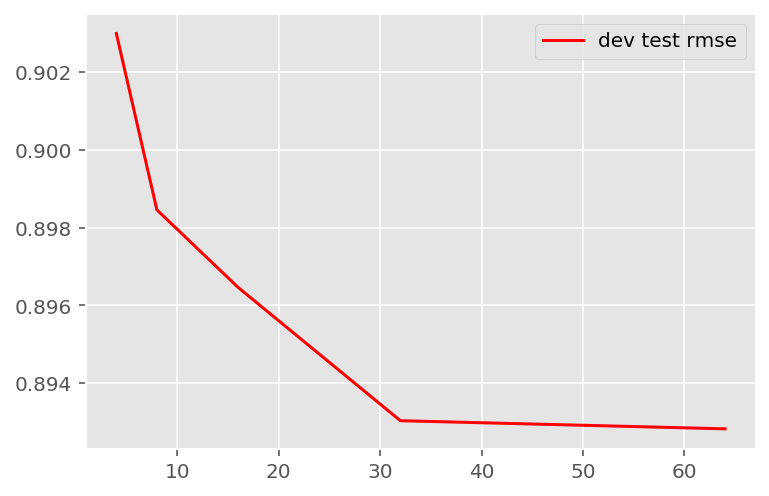

In [33]:
'''rankを大きくした時に性能がどう変わっていくか見てみる'''

# fastFMのパラメータの指定
n_iter = 100
seed = 333

rmse_test = []
# rankを4, 8, 16, 32, 64で探索する
ranks = [4, 8, 16, 32, 64]

# rankを変えて学習・予測を行い、dev_testデータに対するRMSEを獲得する
for rank in ranks:
    fm =  mcmc.FMRegression(n_iter=n_iter, rank=rank, random_state=seed)
    y_pred = fm.fit_predict(X_train, y_train, X_dev_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_dev_test))
    rmse_test.append(rmse)
    print('rank:{}\trmse:{:.3f}'.format(rank, rmse))
    
# 各rankごとのRMSEをプロットする
plt.plot(ranks, rmse_test, label='dev test rmse', color='r')
plt.legend()

In [40]:
# テストデータで評価
seed = 333
fm =  mcmc.FMRegression(n_iter=300, rank=32, random_state=seed)
y_pred = fm.fit_predict(X_train, y_train, X_test)
print('テストデータのRMSE\t{:.3f}'.format(np.sqrt(mean_squared_error(y_pred, y_test))))

テストデータのRMSE	0.921


In [45]:
# 評価値のバラツキに対処するため、評価値の標準化をしてみる
scaler = StandardScaler()
y_train_norm = scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
fm =  mcmc.FMRegression(n_iter=300, rank=32, random_state=seed)
y_pred = fm.fit_predict(X_train, y_train_norm, X_test)
print('--標準化-- テストデータのRMSE\t{:.3f}'.format(np.sqrt(mean_squared_error(scaler.inverse_transform(y_pred), y_test))))

--標準化-- テストデータのRMSE	0.920


## ユーザIDと映画ID以外に、映画の公開年、ユーザの年齢、性別、評価年も加えてみる

In [53]:
# ユーザ情報の読み込み
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols)

# 評価値情報の読み込み
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols)
# unix_timestampをパースした日時をdateフィールドに入れる
ratings['date'] = pd.to_datetime(ratings['unix_timestamp'], unit='s')

# 映画情報を読み込む
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('ml-100k/u.item', sep='|', names = m_cols, usecols=range(5), encoding='latin1')

# 全てのデータフレームをマージする
movie_rating = pd.merge(movies, ratings)
lens = pd.merge(movie_rating, users)

In [55]:
# 各特徴量の前処理
# ユーザIDと映画IDを、ダミー変数に変換するために文字列に変換
lens['user_id'] = lens['user_id'].astype(str)
lens['movie_id'] = lens['movie_id'].astype(str)
# 映画の公開年と評価年をそれぞれリリース年と評価日から抽出
lens['year'] = lens['date'].apply(str).str.split('-').str.get(0)
lens['release_year'] = lens['release_date'].apply(str).str.split('-').str.get(0)

In [56]:
# 特徴量の組み合わせの候補を作る
candidate_columns = [
    ['user_id', 'movie_id', 'release_year', 'age', 'sex', 'year', 'rating'],  # A
    ['user_id', 'movie_id', 'age', 'sex', 'year', 'rating'],  # B
    ['user_id', 'movie_id', 'sex', 'year', 'rating'],  # C
    ['user_id', 'movie_id', 'age', 'sex', 'rating'],  # D
    ['user_id', 'movie_id', 'rating'],  # E
]

(0.88, 0.9)

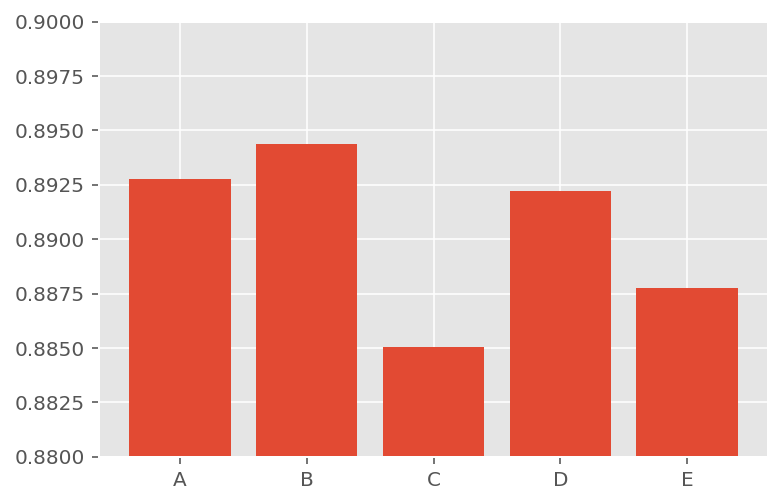

In [59]:
# どの組み合わせが良いか学習してみる
rmse_test = []

# カラム候補群ごとに評価を行う
for column in candidate_columns:
    # 欠損値を落とす
    filtered_lens = lens[column].dropna()
    # 入力データをダミー変数に変換する
    v = DictVectorizer()
    X_more_feature = v.fit_transform(list(filtered_lens.drop('rating', axis=1).T.to_dict().values()))
    # 教師となるレーティングを代入する
    y_more_feature = filtered_lens['rating'].tolist()
    
    # 教師データの学習用と評価用の分割
    X_mf_train, X_mf_test, y_mf_train, y_mf_test = train_test_split(X_more_feature, y_more_feature, test_size=0.1, random_state=42)
    
    # ratingの正規化を行う
    scaler = StandardScaler()
    y_mf_train_norm = scaler.fit_transform(np.array(y_mf_train).reshape(-1, 1)).ravel()
    
    # MCMCを使ったモデルの学習
    fm = mcmc.FMRegression(n_iter=500, rank=8, random_state=123)
    y_pred = fm.fit_predict(X_mf_train, y_mf_train_norm, X_mf_test)
    rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_pred), y_mf_test))
    rmse_test.append(rmse)

# RMSEをプロットする
ind = np.arange(len(rmse_test))
bar = plt.bar(ind, height=rmse_test)
plt.xticks(ind, ('A', 'B', 'C', 'D', 'E'))
plt.ylim((0.88, 0.90))